In [19]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp
import seaborn as sns
# from node2vec import Node2Vec
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from pathlib import Path
import pickle
import glob

In [20]:
from __future__ import division
from __future__ import print_function
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import time
import os
from vgae.optimizer import OptimizerAE, OptimizerVAE
from vgae.model import GCNModelVAE, GCNModelAE
from vgae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges_seed
# os.environ['CUDA_VISIBLE_DEVICES'] = "1" #This tells our program to only see / use GPU1

In [21]:
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() # this would disable tf2 features completely to fully use tf1.x behaviour
tf.set_random_seed(0)

# List physical devices
physical_devices = tf.config.list_physical_devices()
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')


In [22]:
import pickle

with open("features/mpi_network/mpi_Escherichia_coli.pkl", "rb") as f:
    g = pickle.load(f)

print("Graph is: ", g)
print("Type ", type(g))

import pandas as pd

# Edges DataFrame
edges_df = pd.DataFrame(g.edges(data=True), columns=["source", "target", "attrs"])

# Nodes DataFrame
nodes_df = pd.DataFrame(g.nodes(data=True), columns=["node", "attrs"])

print(edges_df.head())

Graph is:  Graph with 1811 nodes and 4288 edges
Type  <class 'networkx.classes.graph.Graph'>
                   source                  target          attrs
0  acetyl-CoA carboxylase      Hydrogen carbonate  {'weight': 1}
1  acetyl-CoA carboxylase              Acetyl-CoA  {'weight': 1}
2  acetyl-CoA carboxylase  Adenosine triphosphate  {'weight': 1}
3  acetyl-CoA carboxylase   Adenosine diphosphate  {'weight': 1}
4  acetyl-CoA carboxylase            Hydrogen Ion  {'weight': 1}


## Read MPI network feature data

In [ ]:
import pandas as pd
node_feats = pd.read_pickle("new_feature_df_Escherichia_coli.pkl")
node_feats.head()
len(node_feats['features'][0])

1024

# VGAE (with feature)

## Read in Graph Data

In [24]:
t = [] # t contains the features of all the nodes.
for fp in node_feats['features'].tolist():
    temp = [i for i in fp]
    t.append(temp)
print(len(t))

1811


In [25]:
features = np.asarray(t) # basically make into numpy array. (btw how is a numpy  list different from a python list? A NumPy array holds only one data type (like all floats or ints) and stores them in continuous memory, so math like addition, multiplication, etc. runs much faster.)

In [26]:
print(features.shape) # there are 1811 nodes each with a feature shape of (1,1024)

(1811, 1024)


In [27]:
adj = nx.adjacency_matrix(g,nodelist=node_feats['node'].tolist()) # The nodelist defines the order — the first node in it maps to row/column 0, the second to 1, and so on.

## Data Preprocessing

In [28]:
# a dense vector stores every value, even zeros. Example: [0, 0, 5, 0, 1]
# a sparse vector stores only nonzero values and their positions to save space. Example: [(2, 5), (4, 1)] means index 2 = 5, index 4 = 1. LIL matrix means list of list matrix, i.e. this (column,value) pairs
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x) 
'''
converts the LIL matrix x into a tuple of (coords, values, shape).

Each entry in coords is a pair (i, j), meaning row i and column j contain a nonzero value.

The actual value at that position is stored in values[z], where z is the same index as in coords[z].

So, for example, if coords[z] = (0, 0), it means row 0, column 0 (node 0’s first feature) has a nonzero entry equal to values[z].

shape simply gives the matrix dimensions.
'''
features_shape = features_tuple[2]
print(x[1])


<List of Lists sparse matrix of dtype 'float64'
	with 0 stored elements and shape (1, 1024)>


In [29]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

In [30]:
# This function splits a graph’s adjacency matrix into train, validation, and test edge sets 
# for link prediction tasks.
#
# Steps:
# 1. Removes self-loops (edges from a node to itself).
# 2. Converts adjacency matrix to a NetworkX graph (g).
# 3. Gets all existing edges (each undirected edge listed only once).
# 4. Randomly selects:
#    - ~10% of edges as test edges
#    - ~5% of edges as validation edges
#    - remaining edges as training edges
#    while ensuring the graph stays connected if prevent_disconnect=True. this happens because often graph models assume the training graph is fully connected
# 5. Creates an equal number of false edges (pairs of unconnected nodes) for each set
#    to serve as negative samples.
# 6. Checks that all edge sets are disjoint (no overlaps between them).
# 7. Builds a new adj_train adjacency matrix containing only training edges.
#
# Returns:
# adj_train,
# train_edges, train_edges_false,
# val_edges, val_edges_false,
# test_edges, test_edges_false
#
# These sets are used to train and evaluate models that predict missing links in the graph.

np.random.seed(0) # IMPORTANT: guarantees consistent train/test splits
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges_seed(adj, test_frac=.1, val_frac=.1,seed=12345)



In [31]:
# Normalize adjacency matrix, and convbert to COO form for easy use (coords, values, shape)
adj_norm = preprocess_graph(adj_train)

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Inspect train/test split
print("Total nodes:", adj.shape[0])
print("Total edges:", int(adj.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 1811
Total edges: 4288
Training edges (positive): 3432
Training edges (negative): 3432
Validation edges (positive): 428
Validation edges (negative): 428
Test edges (positive): 428
Test edges (negative): 428


## Initialize VGAE Model

In [32]:
# Define hyperparameters
LEARNING_RATE = 0.005
EPOCHS = 1000
HIDDEN1_DIM = 32
HIDDEN2_DIM = 16
DROPOUT = 0.1

In [33]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

device = '/GPU:1'  # or '/CPU:0', or any visible GPU

# model, optimizer et are loaded on to the gpu only
with tf.device(device):
    # Define placeholders
    placeholders = { # creating placeholders is basically like typing in tsx. because tensorflow wants to make the computational graph efficient it must know the type of data it will expect. so tensorflow sparse placeholder is basically saying, "i expect a coo format"
        'features': tf.sparse_placeholder(tf.float32),
        'adj': tf.sparse_placeholder(tf.float32),
        'adj_orig': tf.sparse_placeholder(tf.float32),
        'dropout': tf.placeholder_with_default(0., shape=())
    }

    # pos_weight (gives more weight to positive esdges so that the model doesnt just predict zeroes) and norm (normalization factor for loss scaling)
    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

    # Create VAE model
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero, HIDDEN1_DIM, HIDDEN2_DIM)

    # Optimizer
    opt = OptimizerVAE(
        preds=model.reconstructions,
        labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'], validate_indices=False), [-1]),
        model=model, num_nodes=num_nodes,
        pos_weight=pos_weight,
        norm=norm,
        learning_rate=LEARNING_RATE
    )


Creating GAE optimizer...
Labels shape:  (?,)
Preds shape:  (?,)
CE+KL loss shape:  ()


In [34]:
# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, pos_weight, norm, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds_pos = []
    pos = []
    for e in edges_pos:
        preds_pos.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        pos.append(adj_orig[e[0], e[1]]) # actual value (1)

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        neg.append(adj_orig[e[0], e[1]]) # actual value (0)

    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    fpr, tpr, _ = roc_curve(labels_all, preds_all)
    precision, recall, _ = precision_recall_curve(labels_all, preds_all)
    pr_score = auc(recall, precision)
    ap_score = average_precision_score(labels_all, preds_all)
    
    val_loss = norm * tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels=tf.constant(labels_all), logits=tf.constant(preds_all), pos_weight=pos_weight))

    return roc_score, ap_score, fpr, tpr, pr_score, precision, recall, val_loss

In [35]:
EPOCHS = 500

## Train and Evaluate VGAE Model

In [36]:
cost_val = []
acc_val = []
val_roc_score = []
train_loss_log = []
val_loss_log = []
# Initialize session
# Configure GPU
config = tf.ConfigProto() # creating a configuration object, we can specify how cpu/gpu are used, how memory is allocated etc.
config.gpu_options.allow_growth = True # tells tensorflow to start small and grow memory allocation as needed

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer()) # initalises all trainable variables (weights, biases etc) in the model before training starts.

# Train model
for epoch in range(EPOCHS):
    
    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: DROPOUT})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)
    
    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]
    roc_curr, ap_curr, fpr, tpr, pr_score, precision, recall, train_loss_epoch = get_roc_score(train_edges, train_edges_false, pos_weight, norm)
    # Evaluate the tensor first
    train_loss_val = sess.run(train_loss_epoch)   # <-- convert tensor to float
    train_loss_log.append(train_loss_val)

    # Evaluate predictions
    roc_curr, ap_curr, fpr, tpr, pr_score, precision, recall, val_loss_epoch = get_roc_score(val_edges, val_edges_false, pos_weight, norm)
    val_roc_score.append(roc_curr)
    val_loss_val = sess.run(val_loss_epoch)
    val_loss_log.append(val_loss_val)
    
    if (epoch+1)%50 == 0:
    # Print results for this epoch
        print("Cost tensor device:", opt.cost.device)
        print("Accuracy tensor device:", opt.accuracy.device)
        if (epoch+1) % 50 == 0:
            gpus = tf.config.list_physical_devices('GPU')
        for gpu in gpus:
            print("GPU available:", gpu)

        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
              "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
              "val_ap=", "{:.5f}".format(ap_curr),
              "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

I0000 00:00:1763949432.666387 2797039 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37830 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1763949432.666624 2797039 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 24228 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1763949432.666813 2797039 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 15694 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:c1:00.0, compute capability: 8.6


Cost tensor device: /device:GPU:1
Accuracy tensor device: /device:GPU:1
GPU available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU available: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU available: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Epoch: 0050 train_loss= 162.55081 train_acc= 0.16665 val_roc= 0.57026 val_ap= 0.53843 time= 0.68875
Cost tensor device: /device:GPU:1
Accuracy tensor device: /device:GPU:1
GPU available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU available: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU available: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Epoch: 0100 train_loss= 584.38635 train_acc= 0.17735 val_roc= 0.57323 val_ap= 0.54067 time= 0.82209
Cost tensor device: /device:GPU:1
Accuracy tensor device: /device:GPU:1
GPU available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU available: PhysicalD

In [37]:
sns.set_style('ticks') # a global seaborn plotting style which uses clean white backgrounds.

In [38]:
# When we initialize the model, TensorFlow builds a computation graph — a network of tensor ops 
# (like matmul, relu, loss, etc.). Each variable (e.g., model.reconstructions, opt.cost) is a 
# symbolic node in that graph, not an actual value yet.

# When we call `sess.run(some_tensor, feed_dict=...)`, TensorFlow:
# 1. Locates that tensor/node in the graph.
# 2. Traces all ops needed to compute it.
# 3. Replaces placeholders with actual input data (from feed_dict).
# 4. Executes those ops and returns the final numeric result.

# In short: model initialization builds the graph; sess.run() executes part of it to get real values.

In [54]:
train_loss_epoch_val = sess.run(train_loss_epoch)  # get the numeric value
train_loss_log.append(train_loss_epoch_val)
print(train_loss_log)

[32.43663178805066, 32.4366317848463, 32.436631786352606, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.43663178635561, 32.4366317863556, 32.43663178635559, 32.43663178635559, 32.43663178635569, 32.43663178635614, 32.43663178635777, 32.43663178636261, 32.43663178637591, 32.43663178640707, 32.436631786480184, 32.43663178663689, 32.43663178695687, 32.43663178757632, 32.43663178875054, 32.43663179079613, 32.436631794356074, 32.43663180019701, 32.436631809160474, 32.43663182325807, 32.4366318440186, 32.43663187359718, 32.43663191617858, 32.4366319

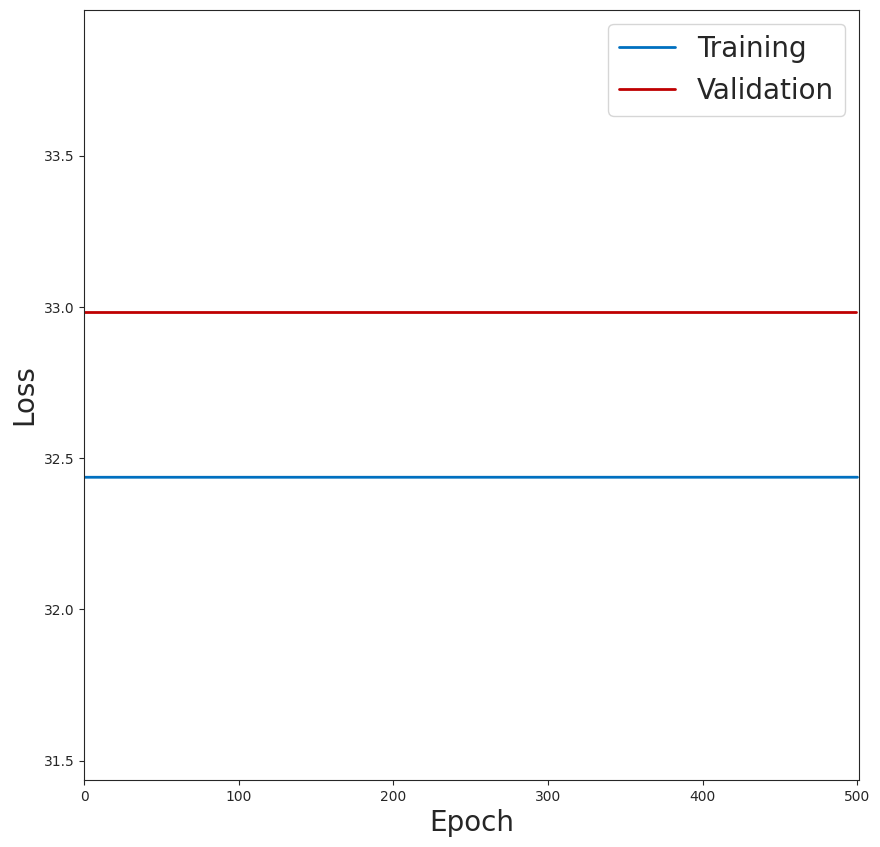

In [40]:
import matplotlib.pyplot as plt

# Make sure train_loss_log and val_loss_log are lists of floats
# e.g., train_loss_log.append(sess.run(train_loss_epoch))

plt.figure(figsize=(10, 10))
lw = 2

plt.plot(range(len(train_loss_log)), train_loss_log, lw=lw, color='#0070c0', label='Training')
plt.plot(range(len(val_loss_log)), val_loss_log, lw=lw, color='#bf0001', label='Validation')

plt.xlim([0, len(train_loss_log)])  # or [0, 1000] if you have 1000 epochs
plt.ylim([min(min(train_loss_log), min(val_loss_log)) - 1, max(max(train_loss_log), max(val_loss_log)) + 1])

plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(loc="upper right", fontsize=20)

plt.savefig("./human_training_loss.pdf")
plt.show()


In [41]:
# Print final results
feature_roc_score, feature_ap_score, feature_fpr, feature_tpr, feature_pr_score, feature_prcs, feature_rcal, test_loss = get_roc_score(test_edges, test_edges_false, pos_weight, norm)
print('Test ROC score: ' + str(feature_roc_score))
print('Test AP score: ' + str(feature_ap_score))

Test ROC score: 0.5836181107520307
Test AP score: 0.5480164678205256


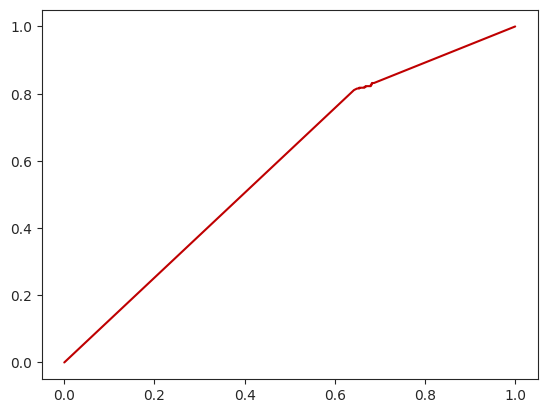

In [42]:
plt.plot(feature_fpr, feature_tpr, color='#bf0001', label='VGAE + Structure')
plt.show()

## Obtain confusion matrix

In [43]:
# this does inference (vae prediction)
def vae_pred(test,feed_dict, emb=None):
    print(type(feed_dict))
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds_pos = []
    pos = []
    for e in test:
        preds_pos.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        pos.append(adj_orig[e[0], e[1]]) # actual value (1)
    return np.array(preds_pos),np.array(pos)

In [44]:
true_test_pred, test_pos = vae_pred(test_edges,feed_dict = feed_dict)
false_test_pred, test_neg = vae_pred(test_edges_false,feed_dict = feed_dict)

<class 'dict'>
<class 'dict'>


### CREATE NEW FEATURES AND PASS THROUGH TRAINED MODEL

In [58]:
# create new_features
import pandas as pd
node_feats = pd.read_pickle("new_feature_df_Escherichia_coli.pkl")
node_feats.head()
len(node_feats['features'][0])
t = [] # t contains the features of all the nodes.
for fp in node_feats['features'].tolist():
    temp = [i for i in fp]
    t.append(temp)
print(len(t))

features = np.asarray(t) # basically make into numpy array. (btw how is a numpy  list different from a python list? A NumPy array holds only one data type (like all floats or ints) and stores them in continuous memory, so math like addition, multiplication, etc. runs much faster.)

print(features.shape) # there are 1811 nodes each with a feature shape of (1,1024)

adj = nx.adjacency_matrix(g,nodelist=node_feats['node'].tolist()) # The nodelist defines the order — the first node in it maps to row/column 0, the second to 1, and so on.
import scipy.sparse as sp
x = sp.lil_matrix(features)
new_features_tuple = sparse_to_tuple(x) 


feed_dict_new = construct_feed_dict(adj_norm, adj_label, new_features_tuple, placeholders)
new_true_test_pred, new_test_pos = vae_pred(test_edges, feed_dict_new, emb=None)


1811
(1811, 1024)
<class 'dict'>


In [59]:
cutoff = 0.67

In [60]:
accepted = []
rejected = []

for edge, score in zip(test_edges, true_test_pred):
    if score >= cutoff:
        accepted.append(edge)
    else:
        rejected.append(edge)


new_accepted = []
new_rejected = []

for edge, score in zip(test_edges, new_true_test_pred):
    if score >= cutoff:
        new_accepted.append(edge)
    else:
        new_rejected.append(edge)
accepted = [tuple(e) for e in accepted]
new_accepted = [tuple(e) for e in new_accepted]
rejected = [tuple(e) for e in rejected]
new_rejected = [tuple(e) for e in new_rejected]

added = [e for e in new_accepted if e not in accepted]
removed = [e for e in accepted if e not in new_accepted]

print(len(added))
print(len(removed))
intersection = list(set(added) & set(removed))
print("Intersection length: ", len(intersection))

0
0
Intersection length:  0


In [48]:
test_TP = true_test_pred[np.where(true_test_pred>=cutoff)]
test_TN = false_test_pred[np.where(false_test_pred<cutoff)]
test_FN = true_test_pred[np.where(true_test_pred<cutoff)]
test_FP = false_test_pred[np.where(false_test_pred>=cutoff)]

In [49]:
N = len(test_TP)+len(test_FP)

In [50]:
test_TPR = len(test_TP)/(len(test_TP)+len(test_FN))
test_FPR = len(test_FP)/(len(test_FP)+len(test_TN))
print('TPR: %.3f' % test_TPR)
print('FPR: %.3f' % test_FPR)

TPR: 0.832
FPR: 0.687


In [51]:
test_Precision = len(test_TP)/(len(test_TP)+len(test_FN))
test_Recall = len(test_TP)/(len(test_TP)+len(test_FP))
print('Precision: %.3f' % test_Precision)
print('Recall: %.3f' % test_Recall)

Precision: 0.832
Recall: 0.548


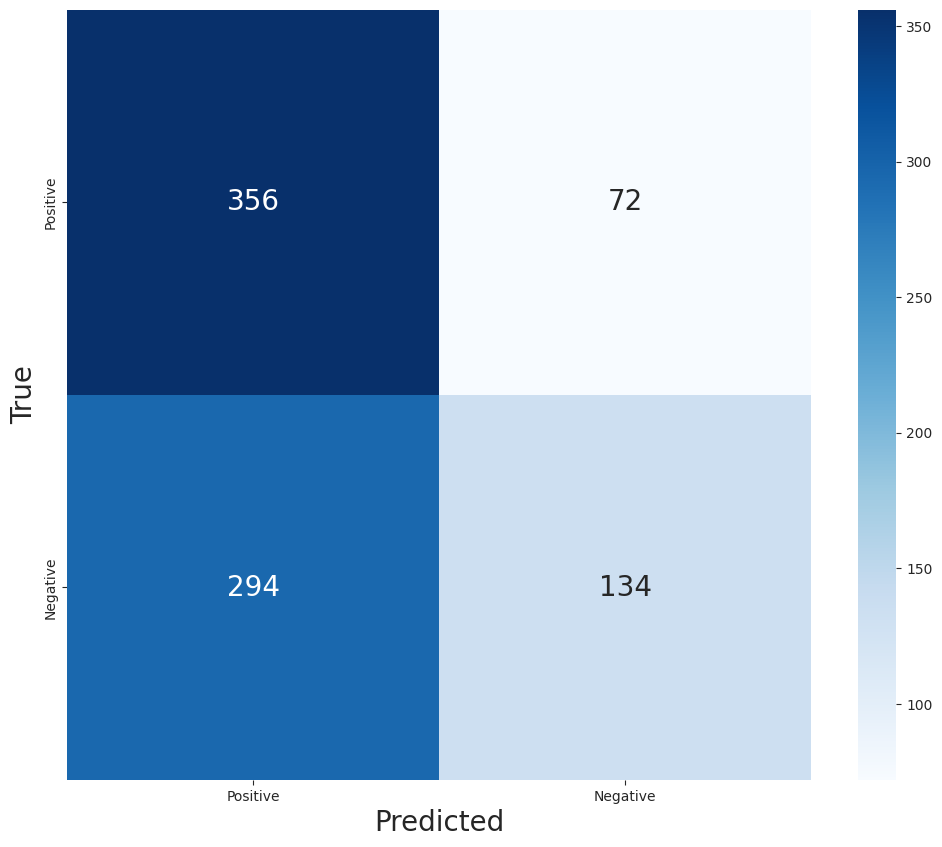

In [52]:
plt.figure(figsize = (12,10))
data = np.array([[len(test_TP),len(test_FN)],[len(test_FP),len(test_TN)]])
df_cm = pd.DataFrame(data, columns=[['Positive','Negative']], index = [['Positive','Negative']])
# sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20},fmt='g')# font size
plt.xlabel('Predicted',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.savefig("./human_confusion_matrix.pdf")
plt.show()